In [ ]:
#importing all the necessities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings("ignore")


In [ ]:
#reading dataset
df = pd.read_csv('/content/laptops.csv')

In [ ]:
df.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


## Data Understanding

In [ ]:
df.describe()

,RAM,Storage,Screen,Final Price
count,2160.000000,2160.000000,2156.000000,2160.000000
mean,15.413889,596.294444,15.168112,1312.638509
std,9.867815,361.220506,1.203329,911.475417
min,4.000000,0.000000,10.100000,201.050000
25%,8.000000,256.000000,14.000000,661.082500
50%,16.000000,512.000000,15.600000,1031.945000
75%,16.000000,1000.000000,15.600000,1708.970000
max,128.000000,4000.000000,18.000000,7150.470000


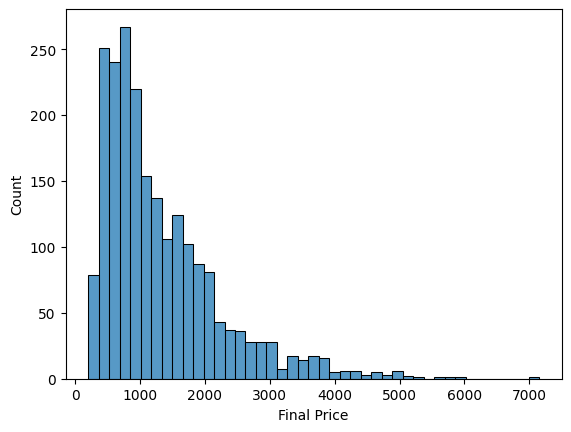

In [ ]:
sns.histplot(data = df, x = df['Final Price'])
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Laptop        2160 non-null   object 
 1   Status        2160 non-null   object 
 2   Brand         2160 non-null   object 
 3   Model         2160 non-null   object 
 4   CPU           2160 non-null   object 
 5   RAM           2160 non-null   int64  
 6   Storage       2160 non-null   int64  
 7   Storage type  2118 non-null   object 
 8   GPU           789 non-null    object 
 9   Screen        2156 non-null   float64
 10  Touch         2160 non-null   object 
 11  Final Price   2160 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 202.6+ KB


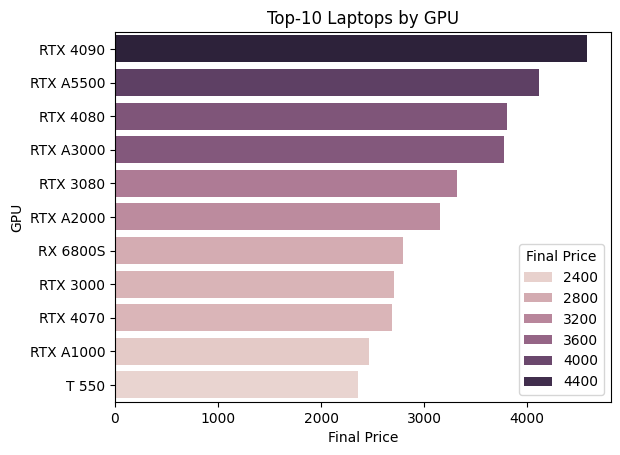

In [ ]:
df_to_plot = df.groupby(by='GPU')['Final Price'].mean().reset_index().sort_values(by='Final Price', ascending=False).reset_index(drop=True).loc[:10, :]
sns.barplot(x='Final Price', y='GPU', data=df_to_plot, hue='Final Price')
plt.title("Top-10 Laptops by GPU")
plt.show()

In [ ]:
#missing GPU values
df['GPU'].isna().sum()

1371

In [ ]:
# Dropping 'GPU' column as it is mostly has no info
df.drop('GPU', axis=1, inplace=True)

In [ ]:
df['Storage'].value_counts(normalize=True) * 100 # percentage of storage values in dataset

,proportion
Storage,
512,43.564815
1000,26.388889
256,20.833333
128,3.101852
2000,1.944444
500,1.712963
64,1.620370
32,0.648148
0,0.046296


In [ ]:
df.isna().sum()

,0
Laptop,0
Status,0
Brand,0
Model,0
CPU,0
RAM,0
Storage,0
Storage type,42
Screen,4
Touch,0


In [ ]:
#There are still some misses in the dataset, but the amount of it is not stistically significant. Lets drop them
df.dropna(inplace = True)

In [ ]:
df.isna().sum()

,0
Laptop,0
Status,0
Brand,0
Model,0
CPU,0
RAM,0
Storage,0
Storage type,0
Screen,0
Touch,0


In [ ]:
df.shape

(2114, 11)

In [ ]:
df.columns

Index(['Laptop', 'Status', 'Brand', 'Model', 'CPU', 'RAM', 'Storage',
       'Storage type', 'Screen', 'Touch', 'Final Price'],
      dtype='object')

In [ ]:
df['Storage type'].value_counts()

,count
Storage type,
SSD,2058
eMMC,56


In [ ]:
# no use of this column as eMMC value are only 2.72% in total
df.drop('Storage type', axis = 1, inplace = True)

In [ ]:
df['Status'].value_counts()

,count
Status,
New,1470
Refurbished,644


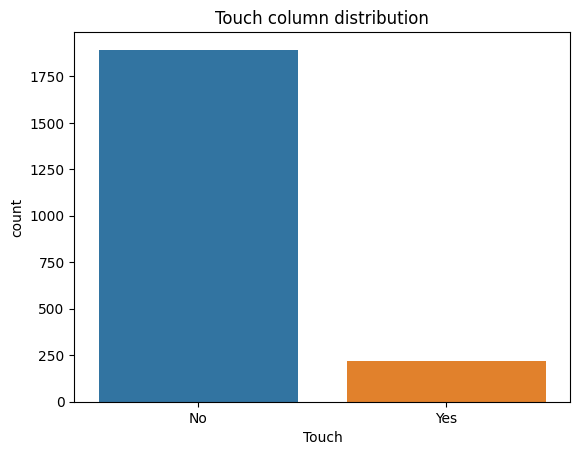

In [ ]:
sns.countplot(x='Touch', data=df, hue='Touch')
plt.title("Touch column distribution")
plt.show()

In [ ]:
df['Model'].value_counts(normalize=True) * 100

,proportion
Model,
15S,5.392621
IdeaPad,4.872280
ROG,4.730369
ThinkPad,4.635762
VivoBook,4.588458
...,...
V17,0.047304
100w,0.047304
ProArt,0.047304


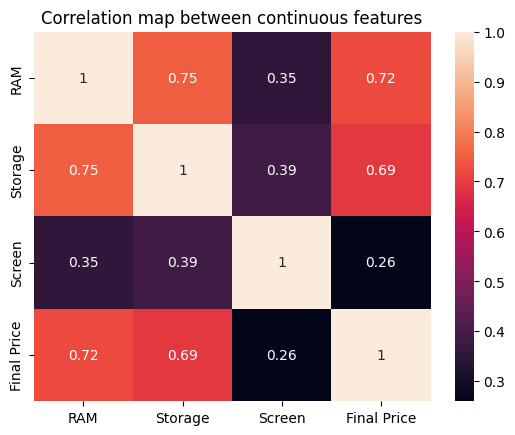

In [ ]:
#Lets check the correlation between price and numeric columns
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.title("Correlation map between continuous features")
plt.show()
#Numeric columns have a good correlation and we do not have to drop any of the columns

## Data Preprocessing

### Cleaning Outliers

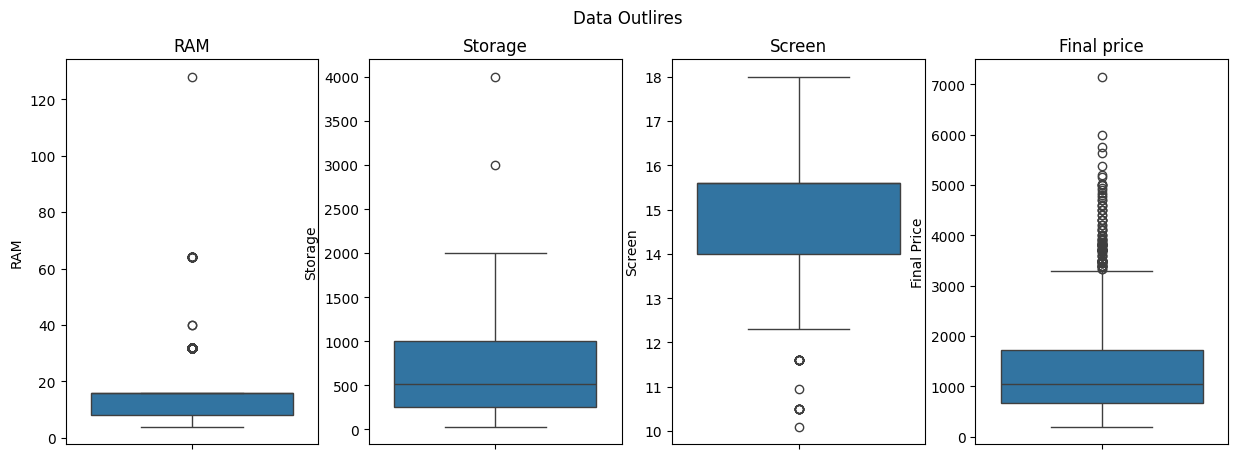

In [ ]:
#lets check outliers in numeric columns and visualize them
fig, axes = plt.subplots(1, 4, sharex=True, figsize=(15,5))
fig.suptitle('Data Outlires')
axes[0].set_title('RAM')
axes[1].set_title('Storage')
axes[2].set_title('Screen')
axes[3].set_title('Final price')
sns.boxplot(ax = axes[0], data = df['RAM'])
sns.boxplot(ax = axes[1], data = df['Storage'])
sns.boxplot(ax = axes[2], data = df['Screen'])
sns.boxplot(ax = axes[3], data = df['Final Price'])
plt.show()

In [ ]:
# Lets count and clean outliers
numeric_cols = df.select_dtypes(exclude = object).drop('RAM', axis=1)

def clean_outliers(col, df):

  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3 - q1
  outliers = df[col].loc[(df[col] < q1 - 1.5 * iqr) | (df[col] > q3 + 1.5 * iqr)] #searching for outliers
  # print(f"Number of {col} outliers: {len(outliers)}")
  df = df.loc[(df[col] >= q1 - 1.5 * iqr) & (df[col] <= q3 + 1.5 * iqr)] #saving data without outliers
  return df

for col in numeric_cols: # cleaning dataset outliers in numeric columns
  df = clean_outliers(col, df)
df.head(10)

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,15.6,No,669.01
5,MSI Crosshair 17 C12VF-264XES Intel Core i7-12...,New,MSI,Crosshair,Intel Core i7,32,1000,17.3,No,1699.00
6,Lenovo Thinkpad E14 Gen 4 AMD Ryzen 5 5625U/8G...,New,Lenovo,ThinkPad,AMD Ryzen 5,8,256,14.0,No,909.00
7,ASUS VivoBook 15 F515JA-EJ2882W Intel Core i7-...,New,Asus,VivoBook,Intel Core i7,8,512,15.6,No,809.01
8,Medion Akoya E15415 Intel Core i5-10210U/8GB/2...,New,Medion,Akoya,Intel Core i5,8,256,15.6,No,519.00
9,HP Victus 16-d1038ns Intel Core i7-12700H/16GB...,New,HP,Victus,Intel Core i7,16,512,16.1,No,1149.00


In [ ]:
df.shape

(1996, 10)

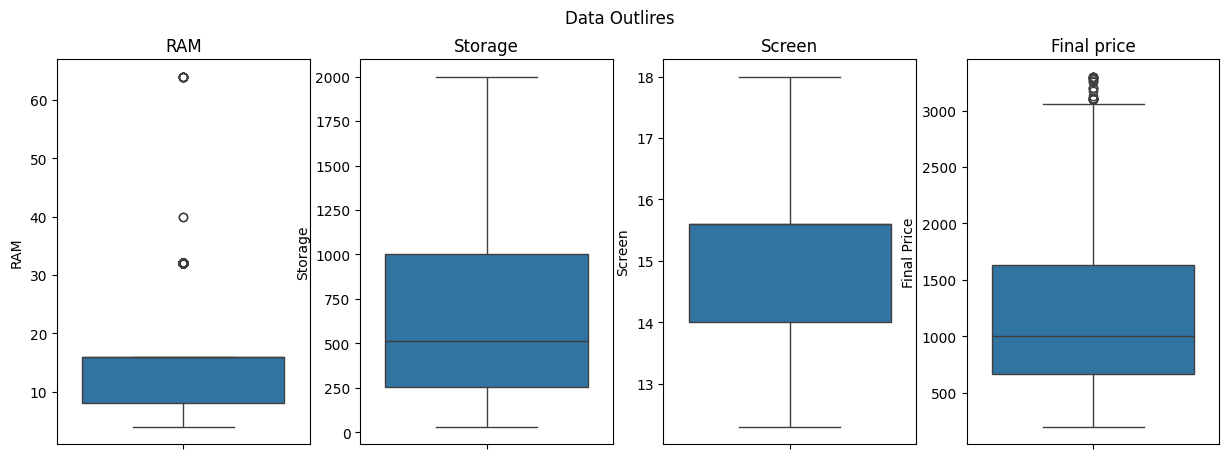

In [ ]:
#lets check boxplots again to see if we still have some outliers
fig, axes = plt.subplots(1, 4, sharex=True, figsize=(15,5))
fig.suptitle('Data Outlires')
axes[0].set_title('RAM')
axes[1].set_title('Storage')
axes[2].set_title('Screen')
axes[3].set_title('Final price')
sns.boxplot(ax = axes[0], data = df['RAM'])
sns.boxplot(ax = axes[1], data = df['Storage'])
sns.boxplot(ax = axes[2], data = df['Screen'])
sns.boxplot(ax = axes[3], data = df['Final Price'])
plt.show()
#Perfect, we dont have outliers

In [ ]:
df.drop(['Laptop', 'Model'], axis=1, inplace=True)

### Encoding categorical features

In [ ]:
# Prediction models won't work with object columns. Lets make some work with them
cat_cols = df.select_dtypes(include = object).drop('Touch', axis=1).columns.tolist()
cat_cols

['Status', 'Brand', 'CPU']

In [ ]:
# Changing Yes/No of 'Touch' values to 0/1
df['Touch'] = df['Touch'].replace({'Yes': 1 , 'No': 0}).astype('int16')

In [ ]:
df['Touch'].value_counts()

,count
Touch,
0,1803
1,193


In [ ]:
df.isna().sum()

,0
Status,0
Brand,0
CPU,0
RAM,0
Storage,0
Screen,0
Touch,0
Final Price,0


In [ ]:
# Encoding object values to make them usable for model learning
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
encoded_data = ohe.fit_transform(df[cat_cols])
df_encoded = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(cat_cols)) #transform encoded data to dataframe with column names
df_encoded.index = df.index # if not do this, missing values will appear
df = pd.concat([df.drop(cat_cols, axis=1), df_encoded], axis = 1) # dropping catecorical columns and joining (using concat) encoded columns instead


In [ ]:
df.head()

,RAM,Storage,Screen,Touch,Final Price,Status_New,Status_Refurbished,Brand_Acer,Brand_Alurin,Brand_Apple,...,CPU_Intel Core i3,CPU_Intel Core i5,CPU_Intel Core i7,CPU_Intel Core i9,CPU_Intel Evo Core i5,CPU_Intel Evo Core i7,CPU_Intel Pentium,CPU_Microsoft SQ1,CPU_Qualcomm Snapdragon 7,CPU_Qualcomm Snapdragon 8
0,8,512,15.6,0,1009.00,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8,256,15.6,0,299.00,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8,256,15.6,0,789.00,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16,1000,15.6,0,1199.00,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,16,512,15.6,0,669.01,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modeling

In [ ]:
X = df.drop('Final Price', axis = 1) # Features
y = df['Final Price'] # Target column

In [ ]:
# splitting data for traininig and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 145, shuffle = True)

In [ ]:
#scaling data to the one and the same demension
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Random Forest

In [ ]:
#firstly use random forest regressor model (rf)
rf = RandomForestRegressor()

In [ ]:
#rf parameters for the grid search
parameters = {
    'n_estimators' : [40, 50, 100, 200, 300],
    'max_depth' : [15, 30, 50, 100]
}

In [ ]:
# using grid search to find more optimal parameters to learn the rf model
grsearch = GridSearchCV(rf, parameters)
grsearch.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [15, 30, 50, 100],
                         'n_estimators': [40, 50, 100, 200, 300]})

In [ ]:
# best parameters
best_model = grsearch.best_estimator_
grsearch.best_params_

{'max_depth': 15, 'n_estimators': 200}

In [ ]:
y_pred = grsearch.predict(X_test)

In [ ]:
# checking metrics score
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print('R2', r2)
print('RMSE', rmse)
print('MAPE', mape)

R2 0.7467841445608046
RMSE 349.5095863810562
MAPE 0.2363277943156788


### XGBoost

In [ ]:
#doing the same thing for the XGBRegressor model
xgb = XGBRegressor()

In [ ]:
parameters = {
    'n_estimators' : [50, 100, 200],
    'max_depth' : [10, 15, 20, 50],
    'learning_rate' : [0.01, 0.02, 0.05, 0.1],
    'booster' : ['gbtree', 'gblinear']
}

In [ ]:
gsearch = GridSearchCV(xgb, parameters)
gsearch.fit(X_train, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'booster': ['gbtree', 'gblinear'],
                         'learning_rate': [0.01, 0.02, 0.05, 0.1],
                         'max_depth': [10, 15, 20, 50],
                         'n_estimators': [50, 100, 200]})

In [ ]:
best_model = gsearch.best_estimator_
gsearch.best_params_

{'booster': 'gbtree',
 'learning_rate': 0.02,
 'max_depth': 10,
 'n_estimators': 200}

In [ ]:
y_pred = gsearch.predict(X_test)

In [ ]:
#that's gonna be the best model
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print('R2', r2)
print('RMSE', rmse)
print('MAPE', mape)


R2 0.7537108813093201
RMSE 344.69601008156314
MAPE 0.2349463727978056


### KNN

In [ ]:
# Tried to use knn, but as I see, that model is mostly acceptable for classification tasks
knn = KNeighborsRegressor()

In [ ]:
parameters = {
    'n_neighbors' : [3, 5, 7, 11, 15],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

In [ ]:
grid_search = GridSearchCV(knn, parameters)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 7, 11, 15]})

In [ ]:
best_model = grid_search.best_estimator_
grid_search.best_params_

{'algorithm': 'auto', 'n_neighbors': 5}

In [ ]:
y_pred = grid_search.predict(X_test)

In [ ]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print('R2', r2)
print('RMSE', rmse)
print('MAPE', mape)

R2 0.6872634553406665
RMSE 388.42123143149627
MAPE 0.23951243563751926
